In [106]:
import pandas as pd 
import numpy as np
import ast 
import matplotlib.pyplot as plt 
import glob
import re 

BUCKET = 'd3-ai-orion'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

BENCHMARK_DATA = pd.read_csv(S3_URL.format(
    BUCKET, 'datasets.csv'), index_col=0, header=None).applymap(ast.literal_eval).to_dict()[1]

# Load datasets 

## mSSA
Something very wrong here... check later 

In [31]:
df_mssa_scores = pd.read_pickle("mssa_scores.pkl").query("mssa_rank == 2")
df_mssa_summary = pd.read_pickle("mssa_summaries.pkl").query("mssa_rank == 2")

In [55]:
df_optmssa_scores = pd.read_pickle("mssa_scores.pkl").sort_values("f1", ascending=False).drop_duplicates("signal", keep="first")
df_optmssa_summary = pd.read_pickle("mssa_summaries.pkl").sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first")

df_optmssa_scores['pipeline'] = "mssa_opt"
df_optmssa_summary['pipeline'] = "mssa_opt"

In [32]:
# df_mssa_summary.groupby("mssa_rank")['f1'].agg([np.mean, np.std])

,mean,std
mssa_rank,,
2,0.513965,0.269561


In [45]:
pd.read_pickle("mssa_summaries.pkl").query("dataset=='YAHOOA3'").sort_values("f1", ascending=False)

,dataset,pipeline,fp,fn,tp,f1,mssa_rank
37,YAHOOA3,mssa,1,0,939,0.999468,3
48,YAHOOA3,mssa,1,15,924,0.991416,4
26,YAHOOA3,mssa,5,67,872,0.960352,2
59,YAHOOA3,mssa,3,105,834,0.939189,5
70,YAHOOA3,mssa,7,205,734,0.873810,6
81,YAHOOA3,mssa,10,289,650,0.813008,7
92,YAHOOA3,mssa,15,358,581,0.757003,8
103,YAHOOA3,mssa,9,433,506,0.696011,9
4,YAHOOA3,mssa,19,467,472,0.660140,None
15,YAHOOA3,mssa,1,496,443,0.640636,1


## Prophet 

In [16]:
df_prophet_scores = pd.read_csv("prophet_deepar_results/final/scores_prophet.csv")
df_prophet_summary = pd.read_csv("prophet_deepar_results/final/summary_prophet.csv")

## DeepAR 

In [17]:
df_deepar_scores = pd.read_csv("prophet_deepar_results/final/scores_deepar.csv")
df_deepar_summary = pd.read_csv("prophet_deepar_results/final/summary_deepar.csv")

## Orbit 

In [24]:
df_orbit_scores = pd.concat([pd.read_pickle("yahoo_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_scores_split_flat.pkl")], ignore_index = True)


df_orbit_summary = pd.concat([pd.read_pickle("yahoo_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_summaries_split_flat.pkl")], ignore_index = True)

# Sanity checks 

In [56]:
#number of summaries 
for df in [df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary]:
    print(len(df))


print("\n\n")

#number of errors in scores 
for df in [df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores]:
    print(len(df))
    print(df.status.value_counts())

    

11
11
11
11
11



492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    472
1     20
Name: status, dtype: int64


# Analyses 

## Scores and durations

In [61]:
pd.concat([df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary], ignore_index=True).loc[:,:"f1"].pivot(index="pipeline", columns="dataset", values="f1").round(2)

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,0.39,0.48,0.65,0.97,0.67,0.52,0.80,0.44,0.48,0.57,0.55
mssa,0.39,0.23,0.69,0.89,0.96,0.69,0.26,0.33,0.53,0.52,0.15
mssa_opt,0.48,0.43,0.75,0.93,1.00,0.90,0.36,0.33,0.59,0.52,0.15
orbit,0.34,0.28,0.81,0.98,1.00,0.87,0.10,0.32,0.53,0.63,0.15
prophet,0.39,0.41,0.54,0.82,0.33,0.17,0.60,0.60,0.47,0.53,0.53


In [68]:
pd.DataFrame(pd.concat([df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores], 
                       ignore_index=True).groupby(['pipeline','dataset'])['elapsed'].agg(np.median).round(2)).reset_index().pivot(index="pipeline", columns="dataset", values="elapsed")

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,267.20,469.50,209.03,216.40,250.86,183.92,271.25,325.97,968.17,399.45,517.01
mssa,0.13,0.29,0.12,0.12,0.12,0.12,0.24,0.21,0.11,0.13,0.61
mssa_opt,0.13,0.30,0.12,0.12,0.12,0.12,0.19,0.20,0.12,0.13,0.62
orbit,20.59,25.89,10.11,9.08,10.72,10.70,19.37,30.63,9.79,13.11,232.25
prophet,222.91,412.51,6.96,11.65,16.73,16.12,227.93,176.53,1146.15,213.28,788.63


## mssa scores with changing rank 

Text(0, 0.5, 'F1 Score')

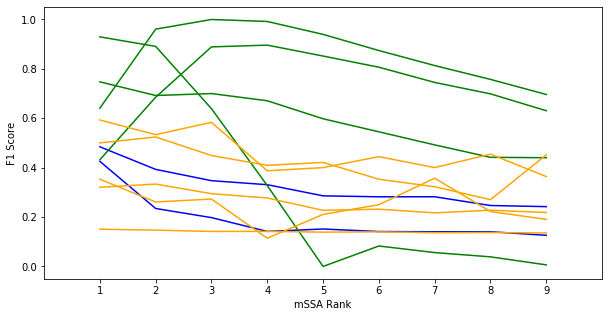

In [99]:
df_allmssa_summaries = pd.read_pickle("mssa_summaries.pkl")

plt.figure(figsize=(10,5))
for dataset in BENCHMARK_DATA.keys():
#     plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
#     plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])

    if dataset in {"SMAP", "MSL"}:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="blue", label="NASA")
    elif "YAHOO" in dataset:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="green", label="Yahoo")
    else:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="orange", label="Numenta")
    
#     plt.title(dataset)

# plt.legend()
plt.xlim(0,10)
plt.xticks(list(range(1,10)))
plt.ylim(-0.05,1.05)
plt.xlabel("mSSA Rank")
plt.ylabel("F1 Score")

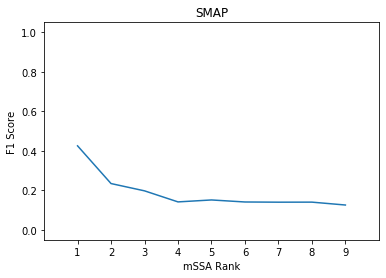

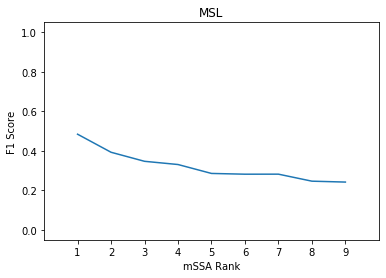

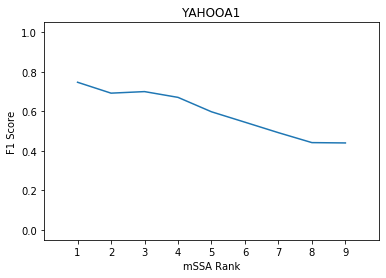

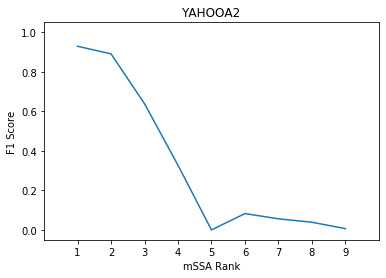

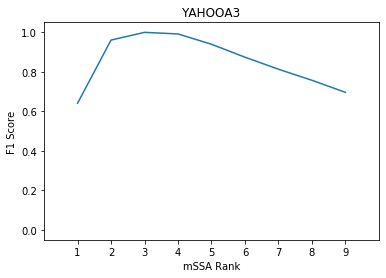

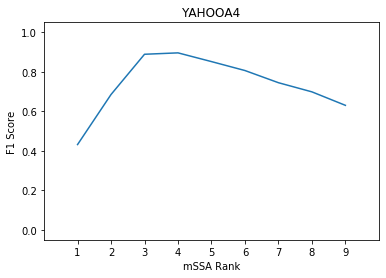

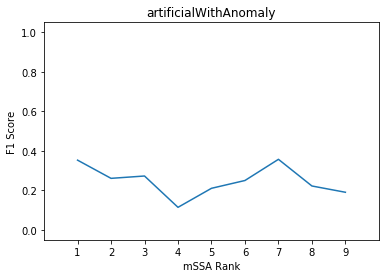

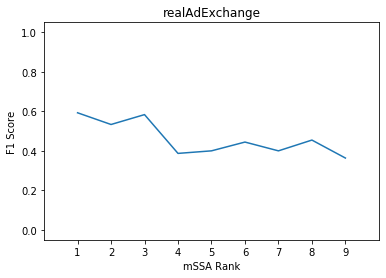

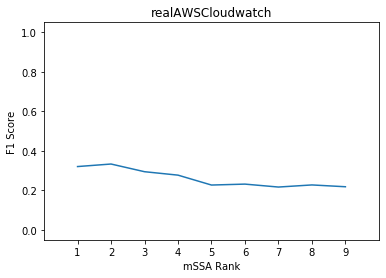

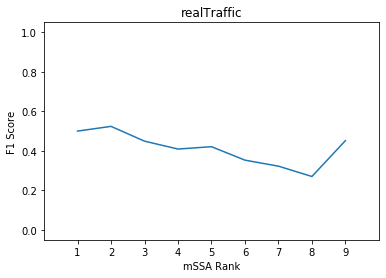

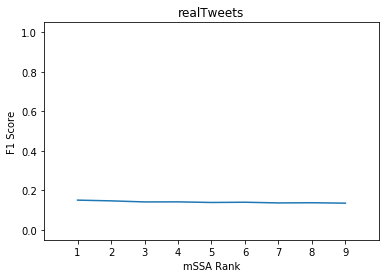

In [98]:
for dataset in BENCHMARK_DATA.keys():
    plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
    plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])
    plt.title(dataset)
    plt.xlabel("mSSA Rank")
    plt.ylabel("F1 Score")
    plt.xlim(0,10)
    plt.xticks(list(range(1,10)))
    plt.ylim(-0.05,1.05)

## Dataset spectral analysis 

In [111]:
#ignore nasa for now, decide how to deal with test/train split later 
filepaths = [x for x in glob.glob("./Orion/orion/data/**", recursive=True) if x.endswith(".csv") and "_all" not in x and "-test" not in x and "-train" not in x]

In [128]:
df_optmssa_spectra = df_optmssa_scores.copy()
spectra_dict = {}



for filepath in filepaths: 
    try:
        signal_name = filepath.split("/")[-1][:-4]

        temp_df = pd.read_csv(filepath)
        m_dim = int(np.sqrt(len(temp_df)))
        n_dim = len(temp_df)//m_dim
        m = np.reshape(temp_df.value.values[:m_dim*n_dim], (m_dim,n_dim))
        m = m - m.mean()

        u,s,_ = np.linalg.svd(m)
        # s = s/s[0]
        S = np.cumsum(s**2)
        S = S/S[-1]

#         df_optmssa_spectra.loc[df_optmssa_spectra['signal'] == signal_name, "energy"] = str(S)
        spectra_dict[signal_name] = S
    
    except:
        print(filepath)

./Orion/orion/data/anomalies.csv


In [132]:
df_optmssa_spectra['energy'] = df_optmssa_spectra['signal'].map(spectra_dict)

In [153]:
#get energy at optimimum level
df_optmssa_spectra.loc[(~df_optmssa_spectra['energy'].isnull()) & (~df_optmssa_spectra['mssa_rank'].isnull()), "optimal_energy_level"] = df_optmssa_spectra[~df_optmssa_spectra['energy'].isnull()][~df_optmssa_spectra['mssa_rank'].isnull()].apply(lambda x: x.energy[int(x.mssa_rank)], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [154]:
df_optmssa_spectra

,pipeline,rank,f1,recall,precision,confusion_matrix,status,elapsed,split,dataset,signal,mssa_rank,fp,fn,tp,energy,optimal_energy_level
0,mssa_opt,1,1.0,1.0,1.0,"(0, 0, 16)",0,0.113083,False,YAHOOA3,A3Benchmark-TS42,None,0,0,16,"[0.9483239274979387, 0.9817714910714394, 0.990...",NaN
1478,mssa_opt,3,1.0,1.0,1.0,"(0, 0, 16)",0,0.118474,False,YAHOOA3,A3Benchmark-TS68,3,0,0,16,"[0.6330894840162906, 0.8722602694985426, 0.924...",0.960544
1484,mssa_opt,9,1.0,1.0,1.0,"(0, 0, 16)",0,0.115984,False,YAHOOA3,A3Benchmark-TS77,3,0,0,16,"[0.6211011707939201, 0.807896586348993, 0.9197...",0.939257
1483,mssa_opt,8,1.0,1.0,1.0,"(0, 0, 16)",0,0.120478,False,YAHOOA3,A3Benchmark-TS49,3,0,0,16,"[0.459111897623467, 0.7447500927940275, 0.8927...",0.906822
1482,mssa_opt,7,1.0,1.0,1.0,"(0, 0, 16)",0,0.114937,False,YAHOOA3,A3Benchmark-TS44,3,0,0,16,"[0.510874609751888, 0.8273311021307374, 0.9441...",0.955952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,mssa_opt,392,0.0,0.0,0.0,"(2, 1, 0)",0,0.197010,True,SMAP,E-3,8,2,1,0,NaN,NaN
4285,mssa_opt,350,0.0,0.0,0.0,"(2, 1, 0)",0,0.128738,False,YAHOOA1,real_45,8,2,1,0,"[0.29622262920030323, 0.4117938387896108, 0.51...",0.805765
4267,mssa_opt,332,0.0,0.0,0.0,"(10, 0, 0)",0,0.220100,False,realAWSCloudwatch,ec2_cpu_utilization_c6585a,8,10,0,0,"[0.12302998057960067, 0.21050122506066699, 0.2...",0.700302
4301,mssa_opt,366,0.0,0.0,0.0,"(3, 1, 0)",0,0.119097,False,YAHOOA2,synthetic_93,8,3,1,0,"[0.9770245208929855, 0.9973441942534007, 0.999...",0.999530


(-0.06517660043816778, 1.065176600371501)

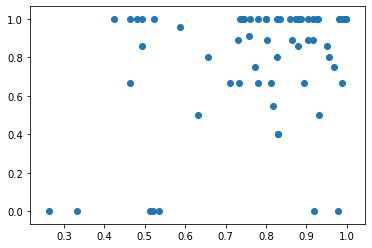

In [158]:
sv_index = 2
dataset = "YAHOOA1"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

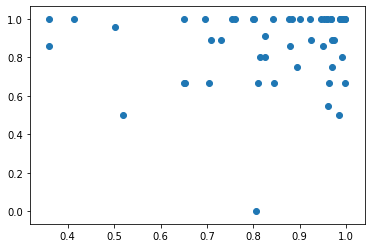

In [155]:
plt.scatter(df_optmssa_spectra.query("dataset == 'YAHOOA1'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'YAHOOA1'")['f1'])

(-0.06517660043650111, 1.065176600336501)

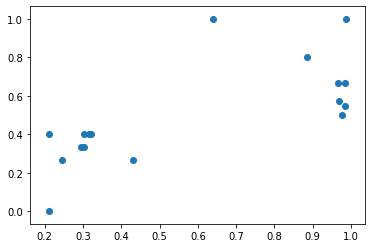

In [162]:
sv_index = 1
dataset = "realAWSCloudwatch"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

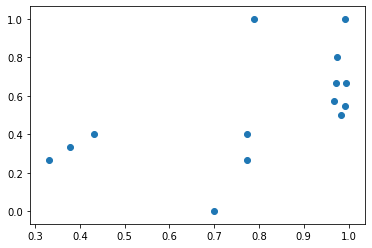

In [157]:
plt.scatter(df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['f1'])

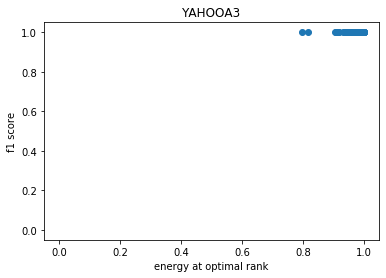

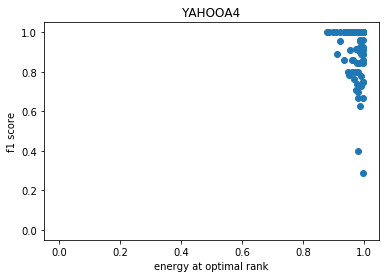

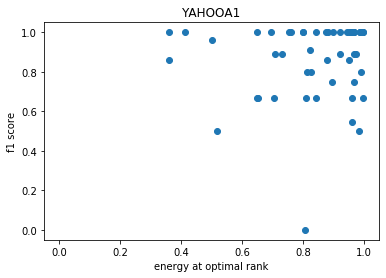

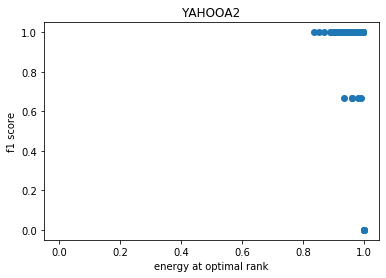

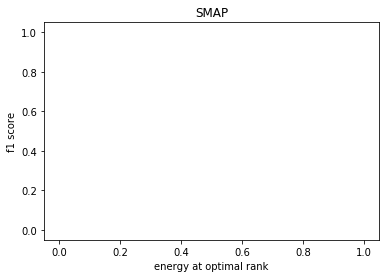

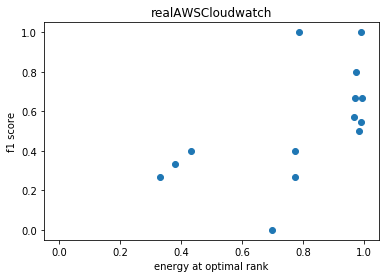

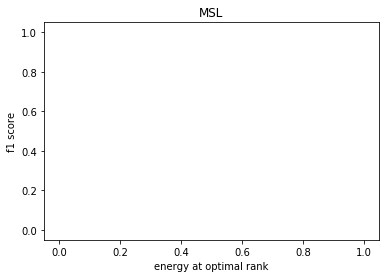

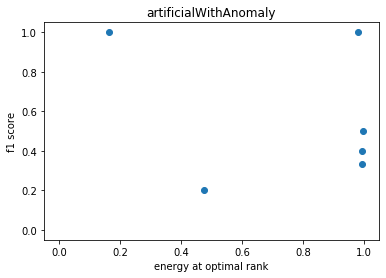

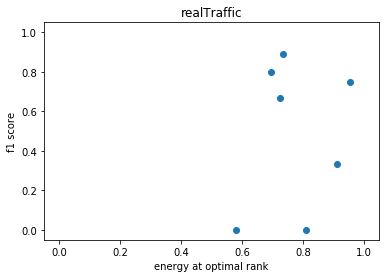

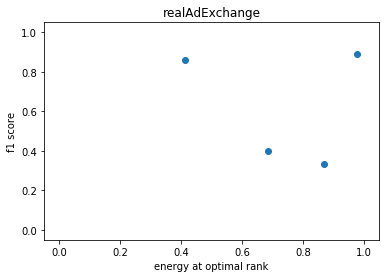

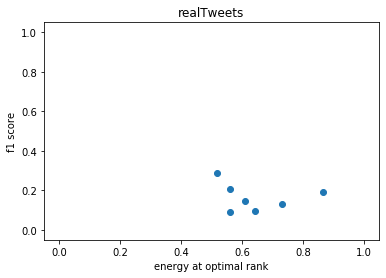

In [169]:
#Caveat: we don't have rank for when "None" is best 

for dataset in df_optmssa_spectra.dataset.unique():
    try:
        plt.figure()
        plt.scatter(df_optmssa_spectra.query("dataset == @dataset")['optimal_energy_level'], df_optmssa_spectra.query("dataset == @dataset")['f1'])
        plt.title(dataset)
        plt.xlabel("energy at optimal rank")
        plt.ylabel("f1 score")
        plt.ylim(-0.05,1.05)
        plt.xlim(-0.05,1.05)
    except:
        print(dataset)

In [171]:
#color by trajectory 

In [172]:
pd.read_csv("./Orion/orion/data/anomalies.csv")

,signal,events
0,P-1,"[[1331272800, 1335592800], [1382832000, 138948..."
1,S-1,"[[1398168000, 1407823200]]"
2,E-1,"[[1393027200, 1393675200], [1406203200, 141648..."
3,E-2,"[[1405944000, 1436119200]]"
4,E-3,"[[1395057600, 1465905600]]"
...,...,...
497,Twitter_volume_GOOG,"[[1426215173,1426406273],[1427001773,142712057..."
498,Twitter_volume_IBM,"[[1427026973,1427265173],[1429434173,1429672373]]"
499,Twitter_volume_KO,"[[1426774373,1426932773],[1428450173,142860857..."
500,Twitter_volume_PFE,"[[1425268373,1425387173],[1425402173,142552097..."
